# Binomial Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.stats import bernoulli
from scipy.optimize import fsolve
from scipy.stats import norm

%matplotlib inline

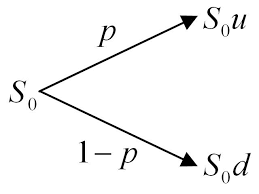

First, we assume a stock moves up a factor of $u$ or down a factor $d$ with a probability of $p$ or $(1-p)$, respectively.  At expiration, we know the price of the option.  It is either 0 if out-of-the-money, or its intrinsic value if in-the-money.

The price at the preceding node is then give by, 
$$C = e^{-rt}(pC_u + (1-p)C_d)$$

If the tree has multiple layers as shown below, we can then repeat the above process to entirely fill out the tree.

In [2]:
#  Manual process for simple two-step tree

#  Our initial stock price
S0 = 100

#  Time to expiration in years
t = 1

#  Assumed up and down percentages
u = 1.05
d = 1/u

#  Probability of an up move
p = 0.6

#  Stock price at expiration
S_u = u * S0
S_d = d * S0

#  Option strike price and risk-free rate
K = 102.5
r = 0.01

#  Call price at up node
C_u = S_u - K

#  Call price at down node
C_d = 0

#Print out the stock prices at expiration
#print(S_u, S_d)

#  Calculate and print the call price at t = 0
C = np.exp(-r * t) * ( p*C_u + (1-p)*C_d)
print(C)

1.485074750623752


A multi-level tree might look like:
![Img](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2e/Arbre_Binomial_Options_Reelles.png/500px-Arbre_Binomial_Options_Reelles.png)

In [3]:
#  Define the number of layers
N = 50

#  Time to expiration, the we rescale it to time per layer step
t = 1
t = t / (N - 1)

#  Iniital stock price, strike price, and risk-free rate
S0 = 100
K = 102.5
r = 0.01

#  Assume a volatility and calculate the size of an up move, down move, and probability
sigma = 0.4
u = np.exp(sigma * np.sqrt(t))
d = 1/u
p = (np.exp(r * t) - d) / (u - d)

#  Create some empty matrices to hold our stock and call prices.
stock_prices = np.zeros( (N, N) )
call_prices = np.zeros( (N, N) )

#  Put our initial price in the matrix
stock_prices[0,0] = S0

#  Fill out the remaining values
for i in range(1, N):
    M = i + 1
    stock_prices[i, 0] = d * stock_prices[i-1, 0]
    for j in range(1, M):
        stock_prices[i, j] = u * stock_prices[i - 1, j - 1]
 
#  Calculate the call price at expiration.  if the call price is less than zero, it is out-of-the-money so we replace those values with zero.
expiration = stock_prices[-1,:] - K
expiration.shape = (expiration.size, )
expiration = np.where(expiration >= 0, expiration, 0)

#  Set the last row of the call matrix to our expiration values
call_prices[-1,:] =  expiration

#  Backpropagate to filll out our tree
for i in range(N - 2,-1,-1):
    for j in range(i + 1):
        call_prices[i,j] = np.exp(-r * t) * ((1-p) * call_prices[i+1,j] + p * call_prices[i+1,j+1])

#plt.spy(call_prices)
print(call_prices[0,0])

15.28912682401203


##  Implied Volatility Calculation

Recall that we want to solve the model for $\sigma$.  In other words, this is a root finding problem as we’ve discussed in the past.  We are solving a problem of the form,
$$f(\sigma) = 0.$$

Specifically, the function $F$ is,
$$\mbox{Binomial}(\sigma) - \mbox{Actual Option Price} = 0$$

We can cast the above equation as a Python function and solve it via Scipy's <i>fsolve</i> function.

First, let's wrap the above model calculation in a function for ease of use.  Then we'll code up the objective function to be passed to fsolve.

In [4]:
def binomial(sigma, S, K, r, t, N, option_type = 'C'):
    
    t = 1; t = t / (N-1)

    S0 = S

    u =  np.exp(sigma * np.sqrt(t))
    d = 1/u
    p = (np.exp(r * t) - d) / (u - d)
    
    stock_prices  = np.zeros( (N, N) )
    option_prices = np.zeros( (N, N) )

    stock_prices[0, 0] = S0
    
    #  Fill out the remaining values
    for i in range(1, N ):
        M = i + 1
        stock_prices[i, 0] = d * stock_prices[i-1, 0]
        for j in range(1, M ):
            stock_prices[i, j] = u * stock_prices[i - 1, j - 1]
 
    #  Calculate the option price at expiration.  if the call price is less than zero, it is out-of-the-money so we replace those values with zero.
    if option_type == 'C':
        expiration = stock_prices[-1,:] - K
    else:
        expiration = K - stock_prices[-1,:]
        
    expiration.shape = (expiration.size, )
    expiration = np.where(expiration >= 0, expiration, 0)

    #  Set the last row of the call matrix to our expiration values
    option_prices[-1,:] =  expiration

    #  Backpropagate to filll out our tree
    for i in range(N - 2,-1,-1):
        for j in range(i + 1):
            option_prices[i,j] = np.exp(-r * t) * ((1-p) * option_prices[i+1,j] + p * option_prices[i+1,j+1])

    return option_prices[0,0]

#  This is out objective function
def objective(sigma, S, K, r, t, N, C0):
    res = binomial(sigma, S, K, r, t, N) - C0
    return res

In [5]:
#  Parameters from above.
N = 5
t = 1
S0 = 100
K = 102.5
r = 0.01

#  We'll use the option price calculated above
C0 = 14.72

#  Wrap the addition arguments in a tuple
args = (S0, K, r, t, N, C0)

#  Solve the problem via fsolve
fsolve(objective, 0.25, args = args)

array([0.40027884])

## Comparison with Black-Scholes

We pull in the Black-Scholes model from a previous video and calculate the option price based on a 40% IV.

The discrepancy in the option price from Black-Schole compared to the binomial model is the number of nodes used.  If we increase the number of nodes, the two models agree.

In [6]:
def call_price(sigma, S, K, r, t):
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    C = np.multiply(S, norm.cdf(d1)) - \
        np.multiply(norm.cdf(d2) * K, np.exp(-r * t))
    return C

def put_price(sigma, S, K, r, t):
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    P = -np.multiply(S, norm.cdf(-d1)) + \
        np.multiply(norm.cdf(-d2) * K, np.exp(-r * t))
    return P

In [7]:
#  Calculate the call price
call_price(0.40, S0, K, r, t)

15.239829429316998